<a href="https://colab.research.google.com/github/takuminmin-m/hisseki_test_py/blob/main/hisseki.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ランタイムの接続が切れないようにするJavaScriptコード
DevToolsのコンソールに入力

JavaScript code to stop for the runtime to disconnect 

```javascript
function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click();
}
setInterval(KeepClicking,60000);
```



# データのインポート import data
google driveをマウント

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


ライブラリの読み込みなど

Load libraries and more

In [2]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

import os
import numpy as np
import IPython.display as display
import random
import matplotlib.pyplot as plt
import pathlib

AUTOTUNE = tf.data.experimental.AUTOTUNE

作業ディレクトリの移動とデータの読み込み

Change the working directory and load labels.txt and handwriting images

/content/drive/MyDrive/colab/hisseki_test_py


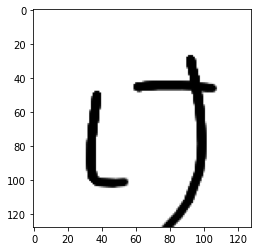

In [3]:
%cd /content/drive/MyDrive/colab/hisseki_test_py

def preprocess_image(image):
  image_4ch = tf.image.decode_image(image, channels=4, expand_animations=False)
  image_4ch = tf.image.resize(image_4ch, [128, 128])
  # image = tf.cast(tf.reduce_sum(image_4ch, 2, keepdims=True), tf.float32)
  # image /= 255.0  # normalize to [0,1] range
  image_4ch /= 255.0

  return image_4ch

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

label_file = open("tf_datas/labels.txt")
labels_str = label_file.readlines()
label_file.close()
all_labels = list(map(lambda str: int(str), labels_str))

data_num = len(all_labels)
image_paths = []
for i in range(data_num):
  image_paths.append("/content/drive/MyDrive/colab/hisseki_test_py/tf_datas/hisseki%d.png" % i)

image_paths = tf.data.Dataset.from_tensor_slices(image_paths)
all_images = list(image_paths.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE))
all_datas = []
for i in range(data_num):
  all_datas.append({"image": all_images[i], "label": all_labels[i]})

# ランダムに画像をテスト表示
# randomly choose a handwriting image and show to test
plt.imshow(random.choice(all_images))
plt.grid(False)
plt.show()

教師データの前処理

Preprocess training data

In [4]:
def split(list, slice_index):
  shuffled_list = list
  random.shuffle(shuffled_list)
  return shuffled_list[:slice_index], shuffled_list[slice_index:]

def separate_image_and_label(list):
  images = []
  labels = []
  for i in range(len(list)):
    images.append(list[i]["image"])
    labels.append(list[i]["label"])
  return images, labels

random.shuffle(all_datas)
slice_index = int(data_num * 0.9)
train_datas, test_datas = split(all_datas, slice_index)

train_images, train_labels = separate_image_and_label(train_datas)
test_images, test_labels = separate_image_and_label(test_datas)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# モデルを作成 Make a model

モデルの設定

Set model

In [5]:
model = keras.Sequential([
    layers.Conv2D(32, (7, 7), activation="relu", input_shape=(128, 128, 4)),
    layers.MaxPooling2D((4, 4)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(data_num, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 122, 122, 32)      6304      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                5

# 評価 Evaluation

In [6]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
5/5 [==============================] - 4s 683ms/step - loss: 4.8136 - accuracy: 0.0710
Epoch 2/10
5/5 [==============================] - 3s 696ms/step - loss: 3.3290 - accuracy: 0.2387
Epoch 3/10
5/5 [==============================] - 3s 684ms/step - loss: 1.3364 - accuracy: 0.5742
Epoch 4/10
5/5 [==============================] - 4s 692ms/step - loss: 0.5402 - accuracy: 0.8516
Epoch 5/10
5/5 [==============================] - 3s 679ms/step - loss: 0.3933 - accuracy: 0.8774
Epoch 6/10
5/5 [==============================] - 4s 714ms/step - loss: 0.4457 - accuracy: 0.8710
Epoch 7/10
5/5 [==============================] - 3s 685ms/step - loss: 0.1770 - accuracy: 0.9677
Epoch 8/10
5/5 [==============================] - 3s 689ms/step - loss: 0.0960 - accuracy: 0.9871
Epoch 9/10
5/5 [==============================] - 4s 707ms/step - loss: 0.0737 - accuracy: 1.0000
Epoch 10/10
5/5 [==============================] - 4s 734ms/step - loss: 0.0426 - accuracy: 1.0000


テスト

test

In [7]:
model.evaluate(test_images, test_labels, verbose=2)

1/1 - 0s - loss: 1.1543 - accuracy: 0.7778


[1.1543351411819458, 0.7777777910232544]